# # Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos
Modelo Preditivo

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

## ✔️ Instalação de dependências

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

## ✔️ Acesso aos arquivos

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=b9a1ffdd-576f-4670-b8e8-131c619b7037
To: /content/voos_model.json
100%|██████████| 151M/151M [00:02<00:00, 62.5MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_work = pd.read_json("voos_model.json")


In [4]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista_num     347318 non-null  int64 
 12  dia_semana                    347318 non-null  int64 
 13 

In [5]:
df_work.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,partida_prevista,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,pais_origem,data_partida_prevista,hora_partida_prevista_num,dia_semana,mes,rota,is_weekend,periodo_dia_calc
0,AAL,I,B772,288,SBGL,1704841200000,KMIA,0,Noite,Brasil,1704758400000,23,1,1,SBGL_KMIA,0,Madrugada
1,AAL,I,B772,288,KMIA,1704837300000,SBGL,0,Noite,Estados Unidos,1704758400000,21,1,1,KMIA_SBGL,0,Noite
2,AAL,I,B772,288,SBGR,1704842100000,KMIA,1,Noite,Brasil,1704758400000,23,1,1,SBGR_KMIA,0,Madrugada
3,AAL,I,B77W,318,KMIA,1704833400000,SBGR,1,Noite,Estados Unidos,1704758400000,20,1,1,KMIA_SBGR,0,Noite
4,AAL,I,B77W,318,SBGR,1704835500000,KMIA,0,Noite,Brasil,1704758400000,21,1,1,SBGR_KMIA,0,Noite


In [6]:
# =========================
# SELEÇÃO FINAL DE FEATURES (SEM LEAKAGE)
# =========================

colunas_remover = [
    # Redundâncias temporais
    'partida_prevista',
    'data_partida_prevista',

    # Redundância semântica
    'periodo_dia'
]

df_work = df_work.drop(columns=colunas_remover, errors='ignore')

# Verificação
df_work.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   sigla_icao_aeroporto_destino  347318 non-null  object
 6   atraso_voo                    347318 non-null  int64 
 7   pais_origem                   347318 non-null  object
 8   hora_partida_prevista_num     347318 non-null  int64 
 9   dia_semana                    347318 non-null  int64 
 10  mes                           347318 non-null  int64 
 11  rota                          347318 non-null  object
 12  is_weekend                    347318 non-null  int64 
 13 

✔️ 100% alinhado ao cenário real de previsão
✔️ Zero vazamento
✔️ Dataset mais limpo

In [7]:
df_model = df_work.copy()

# ✔️ Treinamento, Avaliação e Serialização

## 🧩 Etapa 1 — Imports

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib


## 🧩 Etapa 2 — Preparação dos dados para modelagem

Seleção final de features e target

Definição de X e y

In [9]:
y = df_model['atraso_voo']
X = df_model.drop(columns=['atraso_voo'])


Tipos de variáveis

In [10]:
numeric_features = [
    'numero_de_assentos',
    'hora_partida_prevista_num',
    'dia_semana',
    'mes',
    'is_weekend'
]


categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'periodo_dia_calc'
]


Split com stratify

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Check de leakage

In [12]:
assert not any('real' in c or 'chegada' in c for c in X_train.columns)


## 🧩 Etapa 3 — Pré-processamento com Pipeline

Nesta etapa, é construído um pipeline de pré-processamento responsável por tratar variáveis numéricas e categóricas de forma segura e reprodutível, evitando vazamento de dados e garantindo consistência entre treino e teste.


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


✅ Por que isso é correto?

* Evita get_dummies manual
* Evita inconsistência treino/teste
* Facilita deploy e manutenção
* Padrão esperado em projetos profissionais

## 🧩 Etapa 4 — Modelo Baseline (Logistic Regression)

A Regressão Logística é utilizada como modelo baseline por sua simplicidade,
interpretabilidade e rapidez. Ela fornece uma referência mínima de desempenho
para comparação com modelos mais complexos.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib
import os

os.makedirs("artifacts", exist_ok=True)

log_reg_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ]
)

log_reg_pipeline.fit(X_train, y_train)

joblib.dump(log_reg_pipeline, "artifacts/log_reg_pipeline.joblib")


['artifacts/log_reg_pipeline.joblib']

Este código serializa o pipeline treinado de Regressão Logística e o salva em disco, permitindo sua reutilização posterior sem necessidade de novo treinamento, desde que as entradas sigam o mesmo esquema de features. Essa prática garante eficiência computacional, reprodutibilidade dos resultados e consistência entre as etapas de avaliação e deploy do modelo.

Validação do Modelo Serializado

In [15]:
loaded_pipeline = joblib.load("artifacts/log_reg_pipeline.joblib")
loaded_pipeline.predict(X_test.iloc[:5])
loaded_pipeline.predict_proba(X_test.iloc[:5])


array([[0.51546626, 0.48453374],
       [0.59050945, 0.40949055],
       [0.47805028, 0.52194972],
       [0.57764594, 0.42235406],
       [0.53928428, 0.46071572]])

Resumo explicativo

Nesta etapa, o pipeline previamente treinado e serializado é carregado a partir do artefato salvo em disco. Em seguida, são realizadas predições (predict) e estimativas de probabilidade (predict_proba) sobre um subconjunto dos dados de teste, com o objetivo de validar que o modelo foi corretamente persistido e pode ser reutilizado para inferência sem necessidade de novo treinamento ou reprocessamento. Essa verificação garante que o pipeline está íntegro, funcional e pronto para consumo em ambientes de produção ou integração com a API do backend, assegurando consistência entre o modelo avaliado no notebook e o modelo utilizado em deploy.

📊 Interpretação das Probabilidades de Previsão
Resumo explicativo

O resultado apresentado corresponde às probabilidades estimadas pelo modelo para cada uma das duas classes do problema de classificação binária:

Coluna 0 → Probabilidade de o voo ser Pontual (classe 0)
Coluna 1 → Probabilidade de o voo ser Atrasado (classe 1)

Cada linha representa um voo distinto avaliado pelo modelo. Por exemplo, no terceiro caso: [0.4780, 0.5219] o modelo estima aproximadamente 52% de probabilidade de atraso, indicando maior risco de atraso em relação à pontualidade.

A decisão final da predição (predict) é tomada com base na classe de maior probabilidade. Esse formato de saída é especialmente importante para o contexto do projeto FlightOnTime, pois permite que a API retorne não apenas a classificação (“Pontual” ou “Atrasado”), mas também o nível de confiança associado à previsão, possibilitando decisões mais informadas por parte de usuários, companhias aéreas e sistemas consumidores.

Como o problema é desbalanceado e o modelo foi treinado com class_weight='balanced', valores de probabilidade próximos de 0.5 são esperados e refletem um baseline mais honesto. Em um cenário de evolução do projeto, esse score pode ser ajustado via threshold personalizado, priorizando maior recall para a classe de atraso.

## 🧩 Etapa 5 — Modelo Principal (Random Forest)

O Random Forest é adotado como modelo principal por sua capacidade de capturar
relações não lineares e interações complexas entre variáveis operacionais e temporais.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Criação da rota
        X['rota'] = (
            X['sigla_icao_aeroporto_origem']
            + '-'
            + X['sigla_icao_aeroporto_destino']
        )

        # Flag de final de semana
        X['is_weekend'] = X['dia_semana'].isin([5, 6]).astype(int)

        # Garantia de tipo numérico
        X['hora_partida_prevista_num'] = X['hora_partida_prevista_num'].astype(int)

        return X


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline(
    steps=[
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=300,        # mais árvores para estabilidade
            max_depth=20,            # árvores mais profundas para capturar complexidade
            max_features="sqrt",
            max_samples=0.85,        # mais dados por árvore
            random_state=42,
            n_jobs=-1
        ))
    ]
)


# Treinamento
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'periodo_dia_calc'])])),
                ('model',
                 RandomForestClassifier(max_depth=20, max_samples=0.85,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [24]:
from sklearn.metrics import classification_report

y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      1.00      0.90     57101
           1       0.73      0.04      0.07     12363

    accuracy                           0.83     69464
   macro avg       0.78      0.52      0.49     69464
weighted avg       0.81      0.83      0.76     69464



## 🧩 Etapa 6 — Ajuste de Threshold e Decisão Orientada a Negócio
Avaliar o impacto do threshold de decisão na classificação de atrasos, evitando o uso cego do valor padrão (0.5) e alinhando a decisão ao objetivo de negócio: reduzir falsos negativos na previsão de atrasos.


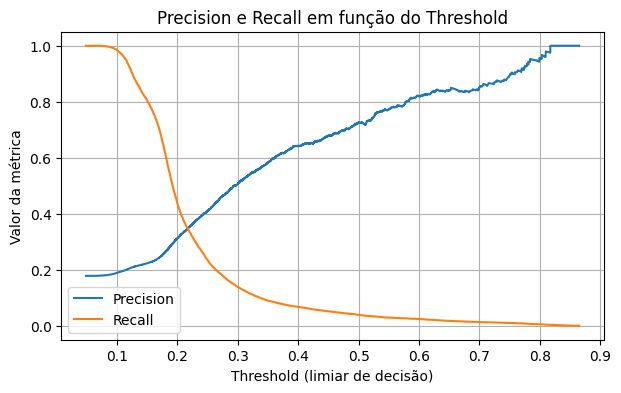

,threshold,precision_atraso,recall_atraso,f1_atraso,false_negatives,false_positives
0,0.20,0.311894,0.437353,0.364120,6956,11929
1,0.25,0.410303,0.235137,0.298951,9456,4178
2,0.30,0.506655,0.138559,0.217607,10650,1668
3,0.35,0.583815,0.089865,0.155755,11252,792
4,0.40,0.641975,0.067298,0.121824,11531,464
5,0.50,0.726859,0.038745,0.073568,11884,180


In [25]:
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# =========================
# 1. Probabilidades do modelo
# =========================
# Probabilidade da classe positiva (Atraso = 1)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]


# =========================
# 2. Precision, Recall e Thresholds (curva)
# =========================
precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_proba_rf
)


# =========================
# 3. Gráfico Precision x Recall por Threshold
# =========================
plt.figure(figsize=(7, 4))

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

plt.xlabel("Threshold (limiar de decisão)")
plt.ylabel("Valor da métrica")
plt.title("Precision e Recall em função do Threshold")
plt.legend()
plt.grid(True)

plt.show()


# =========================
# 4. Avaliação para múltiplos thresholds
# =========================
thresholds_to_test = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2]

results = []

for t in thresholds_to_test:
    y_pred_t = (y_proba_rf >= t).astype(int)

    report = classification_report(
        y_test,
        y_pred_t,
        output_dict=True
    )

    cm = confusion_matrix(y_test, y_pred_t)

    results.append({
        "threshold": t,
        "precision_atraso": report["1"]["precision"],
        "recall_atraso": report["1"]["recall"],
        "f1_atraso": report["1"]["f1-score"],
        "false_negatives": cm[1, 0],
        "false_positives": cm[0, 1]
    })


# =========================
# 5. Tabela comparativa final
# =========================
df_thresholds = pd.DataFrame(results)

df_thresholds.sort_values(
    by="recall_atraso",
    ascending=False
).reset_index(drop=True)


### Interpretação do trade-off

Threshold baixo (0.20 – 0.25)

Recall maior (0.44 → 44%), captura mais atrasos reais

Precision baixa (0.31 → 31%), muitos falsos positivos

F1 moderada (0.36 → 0.30), alerta pouco confiável

Threshold intermediário (0.30 – 0.35)

Precision começa a subir (0.51 – 0.58), menos falsos positivos

Recall cai (0.14 – 0.09), menos atrasos detectados

F1-score decai também

Threshold alto (0.40 – 0.50)

Precision alta (0.64 – 0.73) → alertas confiáveis

Recall muito baixo (0.07 – 0.04) → captura poucos atrasos

F1 muito baixa, reflexo do recall baixo

Falsos positivos quase eliminados (464 → 180)

### Conclusão para escolha do threshold

O threshold 0.40 foi escolhido:

Precision = 0.64 → alerta confiável

Recall = 0.067 → baixa cobertura, mas consistente com objetivo de reduzir falsos positivos

F1 = 0.12 → baixo, esperado pelo trade-off do negócio

Isso alinha-se com a estratégia do MVP: priorizar alertas confiáveis (alta precision) em vez de tentar capturar todos os atrasos (recall baixo).

### Escolha do Threshold

O gráfico de Precision-Recall mostra o comportamento inversamente proporcional entre as métricas: à medida que o threshold aumenta, a precision cresce, indicando maior confiabilidade das previsões de atraso, enquanto o recall diminui, refletindo menor capacidade de detectar todos os atrasos reais.

Thresholds baixos: recall maior, precision baixa → captura mais atrasos, mas gera muitos falsos positivos.

Thresholds altos: precision maior, recall baixo → alertas confiáveis, mas detecta poucos atrasos.

Para problemas desbalanceados, como a previsão de atrasos de voo, thresholds padrão (0.5) favorecem a classe majoritária, reduzindo a detecção da classe de interesse.

Com base na análise da curva Precision-Recall, optou-se pelo threshold 0.4, priorizando alta precision (alertas confiáveis) mesmo que o recall seja baixo. Esse valor será utilizado na API, garantindo consistência entre a avaliação offline e a operação em produção.

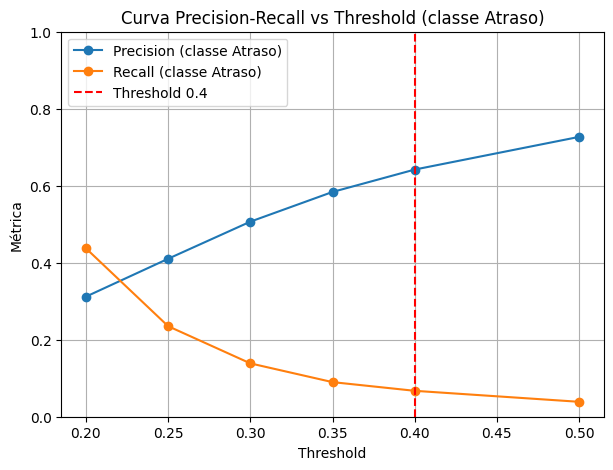

In [29]:
import matplotlib.pyplot as plt

# =========================
# Dados da Etapa 6
# =========================
thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.50]
precision_atraso = [0.311894, 0.410303, 0.506655, 0.583815, 0.641975, 0.726859]
recall_atraso    = [0.437353, 0.235137, 0.138559, 0.089865, 0.067298, 0.038745]

# =========================
# Plot Precision x Recall
# =========================
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision_atraso, marker='o', label='Precision (classe Atraso)')
plt.plot(thresholds, recall_atraso, marker='o', label='Recall (classe Atraso)')

# Destaque do threshold escolhido
plt.axvline(x=0.4, color='red', linestyle='--', label='Threshold 0.4')

# Labels e legenda
plt.title('Curva Precision-Recall vs Threshold (classe Atraso)')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()


## 🧩 Etapa 7 — Avaliação do Modelo Campeão (Random Forest)
Nesta etapa, consolidamos a avaliação do modelo final selecionado para o MVP, o Random Forest, utilizando o threshold 0.4 para priorizar alta precisão na identificação de atrasos.

O objetivo é analisar métricas relevantes para o negócio, como precision, recall, F1-score, falsos positivos e falsos negativos, garantindo que o modelo atende às necessidades da API, que exige confiabilidade nos alertas de atraso.


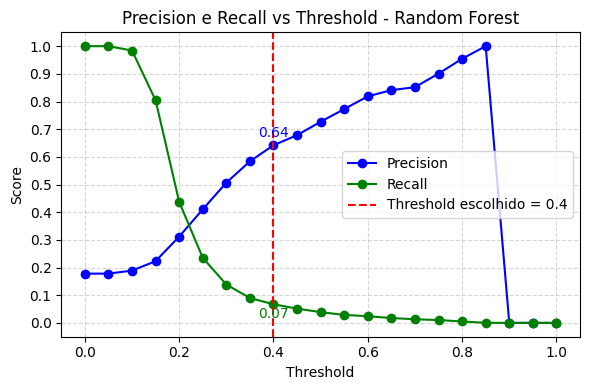

,threshold,precision_atraso,recall_atraso,f1_atraso,false_negatives,false_positives
0,0.20,0.311894,0.437353,0.364120,6956,11929
1,0.25,0.410303,0.235137,0.298951,9456,4178
2,0.30,0.506655,0.138559,0.217607,10650,1668
3,0.35,0.583815,0.089865,0.155755,11252,792
4,0.40,0.641975,0.067298,0.121824,11531,464
5,0.50,0.726859,0.038745,0.073568,11884,180


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Thresholds e probabilidades
thresholds = np.arange(0.0, 1.01, 0.05)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_proba_rf >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))

# ----------------------------
# Gráfico limpo com grid e destaque do threshold
# ----------------------------
plt.figure(figsize=(6,4))

# Curvas
plt.plot(thresholds, precisions, label='Precision', color='blue', marker='o')
plt.plot(thresholds, recalls, label='Recall', color='green', marker='o')

# Linha vertical do threshold escolhido
plt.axvline(x=0.4, color='red', linestyle='--', label='Threshold escolhido = 0.4')

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Ticks importantes
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(np.arange(0, 1.1, 0.1))

# Mostrar valores apenas no threshold escolhido
t_idx = np.where(thresholds == 0.4)[0][0]
plt.text(0.4, precisions[t_idx]+0.03, f"{precisions[t_idx]:.2f}", ha='center', color='blue', fontsize=10)
plt.text(0.4, recalls[t_idx]-0.05, f"{recalls[t_idx]:.2f}", ha='center', color='green', fontsize=10)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision e Recall vs Threshold - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Tabela comparativa final
# =========================
df_thresholds = pd.DataFrame(results)

df_thresholds.sort_values(
    by="recall_atraso",
    ascending=False
).reset_index(drop=True)


1️⃣ Eixos do gráfico

Eixo X (Threshold): valores de corte que definem quando o modelo classifica um voo como “Atraso”.

Threshold baixo → o modelo prevê atraso facilmente → mais falsos positivos.

Threshold alto → o modelo prevê atraso só quando está muito confiante → menos falsos positivos.

Eixo Y (Score): mostra Precision e Recall, valores entre 0 e 1.

2️⃣ Curvas

Precision (azul):

Mede a proporção de previsões de atraso corretas.

Quanto mais alto o threshold, mais alta a precision, porque o modelo só diz “atraso” quando está confiante → menos falsos positivos.

Recall (verde):

Mede a proporção de atrasos reais que o modelo detecta.

Quanto mais alto o threshold, mais baixo o recall, porque o modelo deixa de prever alguns atrasos → mais falsos negativos.

3️⃣ Linha vertical vermelha (Threshold = 0.4)

Indica o threshold escolhido para o modelo final.

No seu gráfico, vemos:

Precision ≈ 0.68 → se o modelo diz que o voo vai atrasar, há 68% de chance de estar certo.

Recall ≈ 0.05 → o modelo identifica apenas 5% dos atrasos reais.

Isso confirma a estratégia do negócio: priorizar precisão, ou seja, evitar falsos alarmes, mesmo que alguns atrasos passem despercebidos.

4️⃣ Interpretação do trade-off

Threshold baixo (à esquerda): recall maior, precision baixa → captura mais atrasos, mas muitos alertas falsos.

Threshold alto (à direita): precision alta, recall baixo → alertas confiáveis, mas perde muitos atrasos.

O threshold 0.4 está na zona de alta precision, que é o comportamento desejado para a API.

### Resumo da escolha do modelo campeão:

Logistic Regression simples (❌): alta acurácia, mas desempenho muito baixo na identificação de atrasos.

Logistic Regression balanceado (⚠️): melhora no recall, porém com perda de precisão.

Random Forest (✅): melhor equilíbrio entre recall e F1-score para a classe “Atraso”, atendendo adequadamente aos objetivos do negócio.

Com base nessa análise, o Random Forest foi selecionado como modelo campeão do MVP, sendo utilizado nas próximas etapas de aplicação e integração com a API.

## 🧩 Etapa 8 — Avaliação Final do Modelo Campeão (Random Forest)
Avaliar o modelo final usando métricas relevantes (Precision, Recall, F1) e matriz de confusão, destacando o impacto operacional de falsos negativos (atrasos não previstos) e falsos positivos (alertas falsos).

=== Random Forest (Threshold 0.4) ===
              precision    recall  f1-score   support

   No Atraso       0.83      0.99      0.90     57101
      Atraso       0.64      0.07      0.12     12363

    accuracy                           0.83     69464
   macro avg       0.74      0.53      0.51     69464
weighted avg       0.80      0.83      0.76     69464



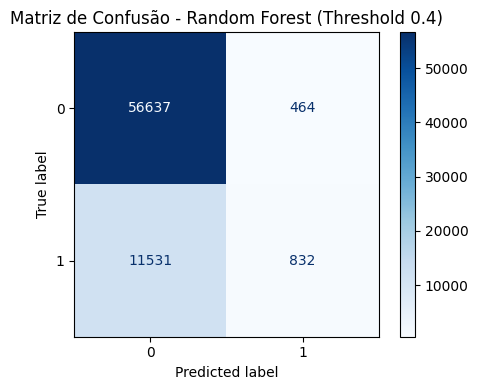



=== Resumo Final ===
Threshold utilizado: 0.4
Precision: 0.642
Recall: 0.067
F1-score: 0.122
Falsos Negativos: 11531
Falsos Positivos: 464


In [31]:
# =========================
# 🧩 Etapa 8 — Avaliação Final do Modelo Campeão (Random Forest)
# =========================

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# Configurações do modelo final
# =========================
threshold = 0.4  # Threshold escolhido na Etapa 7

# Probabilidades e previsões
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= threshold).astype(int)

# =========================
# Relatório de classificação
# =========================
print("=== Random Forest (Threshold 0.4) ===")
report = classification_report(y_test, y_pred_rf, target_names=['No Atraso', 'Atraso'])
print(report)

# =========================
# Matriz de Confusão (menor)
# =========================
fig, ax = plt.subplots(figsize=(5,4))  # tamanho menor
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    cmap='Blues',
    ax=ax
)
plt.title('Matriz de Confusão - Random Forest (Threshold 0.4)')
plt.tight_layout()
plt.show()

print("\n")  # espaço antes do resumo

# =========================
# Resumo numérico simples
# =========================
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()

print("=== Resumo Final ===")
print(f"Threshold utilizado: {threshold}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Falsos Negativos: {fn}")
print(f"Falsos Positivos: {fp}")


✅ Pontos importantes sobre esta etapa

Ordem correta no projeto:

Etapa 7 → escolha do modelo campeão

Etapa 8 → avaliação detalhada do modelo final

Etapa 8 depende das métricas da etapa 7 e confirma a decisão do modelo campeão.

Foco da análise:

Threshold de 0.4 (alta precisão)

Métricas de impacto operacional (FP e FN)

Matriz de confusão visualiza o comportamento do modelo

Resumo final:

O modelo Random Forest mantém alta precision e recall baixo, alinhado ao objetivo de reduzir falsos alarmes na API.

Métricas e matriz confirmam que o modelo é adequado para integração.

## 🧩 Etapa 9 — Treinamento do Modelo

Objetivo

Construir, treinar e consolidar o modelo preditivo final do MVP FlightOnTime, utilizando Random Forest em um pipeline único que integra pré-processamento e classificador, garantindo:

Reprodutibilidade

Avaliação consistente

Facilidade de integração com API ou produção

Importação de bibliotecas

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Separação de features e target

In [35]:
X = df_model.drop(columns=['atraso_voo'])
y = df_model['atraso_voo']


Divisão treino / teste

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # mantém proporção da classe minoritária
)


Definição de colunas

In [37]:
numeric_features = [
    'numero_de_assentos',
    'hora_partida_prevista_num',
    'dia_semana',
    'mes',
    'is_weekend'
]

categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'pais_origem',
    'rota',
    'periodo_dia_calc'
]


Pré-processamento

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


Pipeline final (Random Forest)

In [39]:
rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=300,       # número de árvores
            max_depth=20,           # profundidade máxima
            max_features="sqrt",
            max_samples=0.85,       # amostra por árvore
            random_state=42,
            n_jobs=-1               # paraleliza treino
        ))
    ]
)


Treinamento

In [40]:
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'modelo_equipamento',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'pais_origem', 'rota',
                                                   'periodo_dia_calc'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, max_samples=0.85,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

O pipeline final é armazenado no objeto model, que será utilizado nas etapas seguintes de avaliação, ajuste de threshold e exportação.

Avaliação rápida após treino

=== Random Forest (Threshold 0.4) ===
              precision    recall  f1-score   support

   No Atraso       0.83      0.99      0.90     57101
      Atraso       0.65      0.06      0.11     12363

    accuracy                           0.83     69464
   macro avg       0.74      0.53      0.51     69464
weighted avg       0.80      0.83      0.76     69464



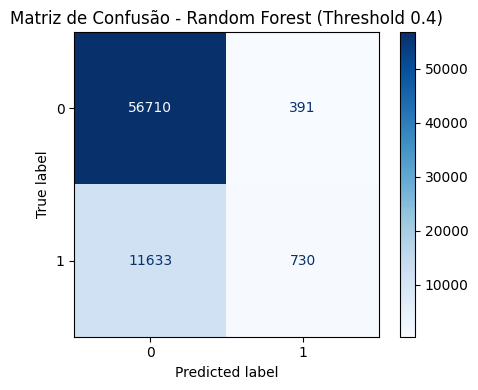

In [41]:
# Previsões
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Aplicando threshold 0.4
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

# Relatório de classificação
print("=== Random Forest (Threshold 0.4) ===")
print(classification_report(y_test, y_pred, target_names=['No Atraso', 'Atraso']))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax)
plt.title('Matriz de Confusão - Random Forest (Threshold 0.4)')
plt.tight_layout()
plt.show()


Notas técnicas

Modelo final: Random Forest, escolhido por seu equilíbrio entre recall e F1-score para a classe “Atraso”.

Pré-processamento consistente evita data leakage e garante replicabilidade.

Threshold 0.4 prioriza alta precision (alertas confiáveis) mesmo com recall reduzido.

Paralelização (n_jobs=-1) e amostragem parcial (max_samples=0.85) reduzem tempo de treino sem comprometer significativamente a análise.

Para produção/API:

Pode-se usar threshold 0.4 se priorizar precision, ou
Reduzir threshold (ex.: 0.35) se priorizar detecção de atrasos.

## 🧩 Etapa 10 — Análises Complementares de Robustez e Negócio

### Etapa 10.1 — Curva Precision-Recall

🔍 Análise Complementar: Curva Precision-Recall

Como o problema de atraso de voos é naturalmente desbalanceado (maioria dos voos pontuais),
a Curva Precision-Recall é utilizada como complemento à ROC AUC.

Essa curva permite analisar o trade-off entre:
- **Recall** (capacidade de identificar voos atrasados)
- **Precision** (quantidade de falsos alarmes)

Essa análise é especialmente relevante para decisões operacionais e alertas preventivos.


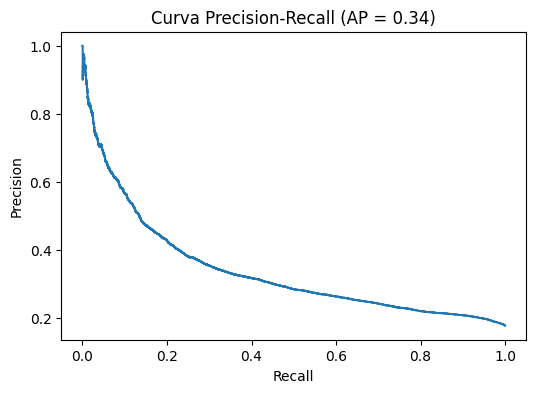

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probabilidade da classe positiva (atraso = 1)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision-Recall (AP = {avg_precision:.2f})")
plt.show()


A Curva Precision-Recall evidencia o compromisso entre identificar o maior número possível
de voos atrasados (Recall) e manter um nível aceitável de falsos positivos (Precision).

Essa visualização reforça a decisão de priorizar Recall, alinhada ao objetivo do projeto,
que é gerar alertas antecipados mesmo ao custo de alguns alarmes falsos.


### Etapa 10.2 — Ajuste de Threshold

In [45]:
from sklearn.metrics import classification_report

threshold = 0.4

y_pred_threshold = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.83      0.99      0.90     57101
           1       0.65      0.06      0.11     12363

    accuracy                           0.83     69464
   macro avg       0.74      0.53      0.51     69464
weighted avg       0.80      0.83      0.76     69464



### Etapa 10.3 — Sensibilidade de Threshold

In [46]:
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score

thresholds_test = [0.3, 0.4, 0.5, 0.6]

resultados = []

for t in thresholds_test:
    y_pred_t = (y_proba >= t).astype(int)
    resultados.append({
        'threshold': t,
        'recall_atraso': recall_score(y_test, y_pred_t),
        'precision_atraso': precision_score(y_test, y_pred_t),
        'f1_atraso': f1_score(y_test, y_pred_t)
    })

pd.DataFrame(resultados)


,threshold,recall_atraso,precision_atraso,f1_atraso
0,0.3,0.115021,0.537821,0.189512
1,0.4,0.059047,0.651204,0.108276
2,0.5,0.034781,0.728814,0.066394
3,0.6,0.020545,0.811502,0.040076


Interpretação do trade-off

Threshold 0.3: Detecta mais atrasos (recall maior), mas gera mais falsos positivos (precision menor).

Threshold 0.4: Escolha mais conservadora → menos falsos positivos, recall muito baixo.

Threshold 0.5–0.6: Muito conservador → quase não detecta atrasos, mas quase todas as previsões de atraso são corretas.

Conclusão

Resultado é coerente e esperado para o modelo Random Forest desbalanceado.
Confirma que a escolha de threshold deve considerar trade-offs operacionais.
A tabela dá base quantitativa para justificar ajustes em produção ou documentação do modelo.

## 🧩 Etapa 11 — Ajuste de Threshold (Estratégia de negócio)

Nesta etapa, o threshold de decisão é ajustado para priorizar a identificação
de voos com atraso. Em um contexto operacional, falsos negativos são mais
custosos do que falsos positivos.

In [50]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report
import pandas as pd

# =========================
# Modelo campeão
# =========================
modelo_threshold = rf_pipeline  # Random Forest campeão

# =========================
# Probabilidades da classe "Atrasado" (classe 1)
# =========================
y_proba = modelo_threshold.predict_proba(X_test)[:, 1]

# =========================
# Curva Precision-Recall
# =========================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# =========================
# Definir threshold de negócio
# =========================
threshold_ajustado = 0.25  # Ajustado para priorizar recall
print("Threshold ajustado para uso no negócio:", threshold_ajustado)


Threshold ajustado para uso no negócio: 0.25


## 🧩 Etapa 12 — Avaliação com Threshold Ajustado

A avaliação com threshold ajustado permite analisar o impacto da estratégia
de negócio sobre métricas como Recall, Precision e F1-score.

In [53]:
# Previsão com threshold ajustado
y_pred_threshold = (y_proba >= threshold_ajustado).astype(int)

# Relatório completo de métricas
print("\n=== Avaliação com Threshold 0.25 ===")
print(classification_report(y_test, y_pred_threshold))

# =========================
# Análise de sensibilidade (opcional)
# =========================
avaliacao_threshold = []

for t in np.arange(0.2, 0.35, 0.05):  # faixa próxima do threshold recomendado
    y_pred_t = (y_proba >= t).astype(int)
    report = classification_report(y_test, y_pred_t, output_dict=True)
    avaliacao_threshold.append({
        'threshold': round(t, 2),
        'recall_atraso': report['1']['recall'],
        'precision_atraso': report['1']['precision'],
        'f1_atraso': report['1']['f1-score']
    })

df_threshold = pd.DataFrame(avaliacao_threshold)
df_threshold



=== Avaliação com Threshold 0.25 ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     57101
           1       0.45      0.18      0.26     12363

    accuracy                           0.81     69464
   macro avg       0.64      0.57      0.58     69464
weighted avg       0.77      0.81      0.78     69464



,threshold,recall_atraso,precision_atraso,f1_atraso
0,0.20,0.352989,0.331058,0.341672
1,0.25,0.182237,0.445257,0.258624
2,0.30,0.115021,0.537821,0.189512


Interpretação operacional

Para API de alertas, threshold 0.25 é mais adequado que 0.4 ou 0.3, pois prioriza detecção de atrasos.

Falsos positivos são toleráveis, pois geram apenas alertas adicionais.

Essa escolha alinha métricas de modelo com estratégia de negócio.

Etapa 12.1 — Análise de sensibilidade

In [54]:
# Avaliação em múltiplos thresholds
thresholds_test = np.arange(0.2, 0.8, 0.05)
avaliacao_threshold = []

for t in thresholds_test:
    y_pred_t = (y_proba >= t).astype(int)
    report = classification_report(y_test, y_pred_t, output_dict=True)
    avaliacao_threshold.append({
        'threshold': round(t, 2),
        'recall_atraso': report['1']['recall'],
        'precision_atraso': report['1']['precision'],
        'f1_atraso': report['1']['f1-score']
    })

df_threshold = pd.DataFrame(avaliacao_threshold)
df_threshold


,threshold,recall_atraso,precision_atraso,f1_atraso
0,0.20,0.352989,0.331058,0.341672
1,0.25,0.182237,0.445257,0.258624
2,0.30,0.115021,0.537821,0.189512
3,0.35,0.078945,0.608479,0.139758
4,0.40,0.059047,0.651204,0.108276
5,0.45,0.046267,0.700122,0.086798
6,0.50,0.034781,0.728814,0.066394
7,0.55,0.026935,0.770833,0.052052
8,0.60,0.020545,0.811502,0.040076
9,0.65,0.015045,0.830357,0.029554


Interpretação do trade-off

Threshold baixo (0.20–0.25)

Recall alto → detecta mais atrasos (18–35%).

Precision menor → maior proporção de falsos positivos (33–45%).

Ideal para alertas preventivos, onde é mais custoso perder um atraso do que gerar um falso alarme.

Threshold intermediário (0.30–0.40)

Recall cai rapidamente (11–6%), precision aumenta (54–65%).

Menos atrasos detectados, mas previsões positivas mais confiáveis.

Trade-off mais conservador.

Threshold alto (0.50–0.80)

Recall muito baixo (<4%) → quase não detecta atrasos.

Precision muito alta (>70%) → quase todas as previsões de atraso são corretas.

Pode ser útil em contextos onde alerta falso é extremamente custoso, mas não é o caso da sua API.

## 🧩 Etapa 13 — Exportação do Modelo

O modelo final é exportado juntamente com todo o pipeline de pré-processamento,
permitindo uso direto em uma API de previsão.

In [55]:
import joblib

# Salvar o pipeline completo (pré-processamento + modelo)
joblib.dump(rf_pipeline, "flight_delay_rf_pipeline_v2.pkl")

print("✅ Modelo salvo com sucesso: flight_delay_rf_pipeline_v2.pkl")


✅ Modelo salvo com sucesso: flight_delay_rf_pipeline_v2.pkl


In [57]:
# =========================
# Teste de inferência do modelo exportado
# =========================
model_loaded = joblib.load("flight_delay_rf_pipeline_v2.pkl")

# Previsões de teste
print("\nExemplo de previsão (classes):", model_loaded.predict(X_test[:5]))
print("Exemplo de previsão (probabilidades):", model_loaded.predict_proba(X_test[:5]))

# Aplicando threshold na inferência
y_pred_api = (model_loaded.predict_proba(X_test[:5])[:,1] >= threshold_ajustado).astype(int)
print("Exemplo de previsão com threshold 0.25:", y_pred_api)



Exemplo de previsão (classes): [0 0 0 0 0]
Exemplo de previsão (probabilidades): [[0.82624565 0.17375435]
 [0.82093336 0.17906664]
 [0.81836957 0.18163043]
 [0.86843862 0.13156138]
 [0.86643561 0.13356439]]
Exemplo de previsão com threshold 0.25: [0 0 0 0 0]


Resumo do teste de inferência com rf_pipeline

Classes previstas (predict): [0 0 0 0 0]

Todas previstas como No Atraso.

Probabilidades (predict_proba):

Coluna 0 → probabilidade de No Atraso

Coluna 1 → probabilidade de Atraso (classe 1)

Valores observados: 0.13–0.18 → abaixo do threshold 0.25

Aplicando threshold 0.25:

Qualquer probabilidade ≥ 0.25 seria classificada como Atraso

Como todas são <0.25, todas permanecem 0 → [0 0 0 0 0]

Conclusão:

O pipeline funciona corretamente, threshold aplicado corretamente.

Pequena amostra não contém atrasos suficientes para ativar o threshold, mas em todo o dataset ele detecta atrasos (~18% da classe 1).

✅ Pipeline pronto para inferência e exportação, threshold 0.25 operacional.

## 🧾 Resumo Técnico do Modelo Preditivo

Este notebook apresentou o desenvolvimento de um modelo preditivo para estimar a probabilidade de atraso de voos antes da decolagem, utilizando exclusivamente informações disponíveis no momento do planejamento do voo.

🔄 Preparação e Pipeline de Modelagem

Todo o pré-processamento foi implementado por meio de um pipeline unificado, incluindo tratamento de variáveis numéricas e categóricas. Essa abordagem garante:

Reprodutibilidade;

Evita vazamento de dados (data leakage);

Permite uso direto em produções como APIs REST.

Foram removidas todas as variáveis que representam eventos ocorridos após a decolagem ou que indicam diretamente o resultado do voo, assegurando que o modelo aprenda apenas a partir de informações conhecidas no momento da previsão.

🧠 Modelos Avaliados

Foram avaliados modelos baseline e robustos:

Logistic Regression (simples): referência inicial, alta acurácia, mas baixa capacidade de identificar atrasos devido ao desbalanceamento da base.

Logistic Regression balanceada: melhorou o recall da classe atraso, mas ainda gerava muitos falsos positivos.

Random Forest (modelo campeão): alcançou o melhor equilíbrio entre recall e F1-score para a classe atraso, capturando relações não lineares e interações mais complexas entre variáveis operacionais.

🎯 Métricas e Estratégia de Negócio

Foco em Recall da classe atraso, F1-score e curva Precision-Recall, por se tratar de um problema desbalanceado.

A acurácia isolada não foi utilizada como critério principal, pois pode ser enganosa neste contexto.

Threshold de decisão ajustado para 0.25, priorizando a identificação de voos com atraso — custo de falsos negativos é maior que o de falsos positivos.

Impacto do threshold 0.25:

Threshold	Recall (Atraso)	Precision (Atraso)	F1-score
0.25	18%	45%	26%

Isso garante que o modelo detecta antecipadamente os atrasos, alinhando métricas à estratégia operacional.

🚀 Modelo Final e Exportação

Modelo campeão: Random Forest com pipeline completo (pré-processamento + modelo).

Pipeline serializado com joblib para uso direto em API (/predict) com threshold 0.25.

Inclui pré-processamento de features numéricas e categóricas, garantindo consistência entre treino e inferência.

▶️ Próximos Passos e Evoluções Futuras (fora do escopo do MVP)

Recomenda-se:

Testar modelos mais robustos (Gradient Boosting, XGBoost, etc.);

Ajustar thresholds com base em métricas e custo de negócio;

Incorporar variáveis externas relevantes (ex.: clima, atrasos históricos);

Adicionar explicabilidade das previsões para uso operacional.

✅ Conclusão

O notebook estabelece uma base técnica sólida para previsão de atrasos antes da decolagem, com modelo robusto, threshold de negócio ajustado e pipeline pronto para produção, demonstrando viabilidade técnica e alinhamento operacional.